# <font size=5, color = 'black'> Notes </font>

Author: Huan Q. Bui

Affiliation: Fermi1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: May 15, 2023

Last updated: May 15, 2023

Description:
- A place to learn how to use QuTip
- A notebook for calculating quantumy stuff using (mostly) QuTip
- Focusing on less "conventional" systems that examples in class
- A visual aid for studying AMO physics
- A place to test code before adding to Fermi1_Calculator notebook

To do:
- Two-level system: single-photon damped Rabi oscillation
- EIT
- STIRAP (with loss, with continuum participation, with Krotov for optimizing pulse shapes, reproduce Yiqi's code, etc.)
- Atom-photon interaction in a cavity
- Statistics of quantum vs classical light?
- Molecular wavefunctions, Van der Waals potential, etc.

# <font size=5, color='black'> Setting up </font>

In [ ]:
# imports
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import scipy
import pandas as pd
from qutip import *
import time

In [ ]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034


# <font size=5, color = 'black'> Two-level atom in a leaky cavity  </font>

Here we consider a system of an atom in a leaky cavity. The cavity and atom share the same resonance frequency. The atom is initially in the ground state. The cavity is initially in an $n$-photon Fock state $\ket{n}$. The "decay rate" of the cavity is given by $\gamma_c$, so the associated collapse operator is $C_c = \sqrt{\gamma_e} a$ where $a$ photon annihilation operator. The projectors for the atom are $\sigma^+, \sigma^-$ as usual. We will solve for the dynamics of the system.

In [53]:
def atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number):
    # convention: atom X photons
    psi0_atom_fock = tensor(fock(atom_space_size,0), fock(fock_space_size, initial_photon_number))
    a  = tensor(qeye(2), destroy(fock_space_size))
    sigma_minus = tensor(destroy(atom_space_size), qeye(fock_space_size))

    # Jaynes-Cummings Hamiltonian
    H = 2*np.pi*(a.dag()*a + sigma_minus.dag()*sigma_minus + atom_cavity_coupling * (sigma_minus * a.dag() + sigma_minus.dag() * a))

    # collapse operators:
    c_op_list = [np.sqrt(cavity_decay_rate)*a]

    # calculate
    result_atom_fock = mesolve(H, psi0_atom_fock, tlist, c_op_list, [a.dag()*a, sigma_minus.dag()*sigma_minus])

    # plot results at short-time limit:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, result_atom_fock.expect[0], label='cavity photon number')
    ax.plot(tlist, result_atom_fock.expect[1], label='excited state population')
    ax.legend()
    plt.ylabel('Expectation values')
    plt.xlabel('Time')
    plt.show()

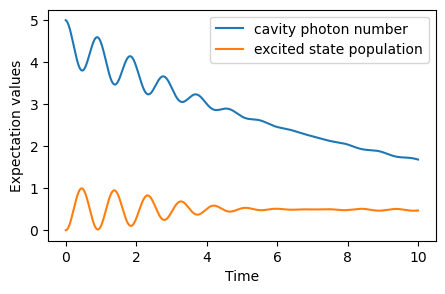

In [51]:
# short-time limit: damped Rabi oscillations
tlist = np.linspace(0,10,10000)
fock_space_size = 10
atom_space_size = 2
atom_cavity_coupling = 0.25
cavity_decay_rate = 0.1
initial_photon_number = 5

atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number)


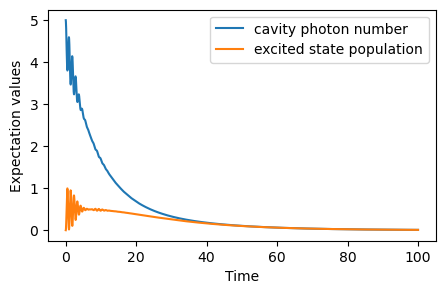

In [52]:
# long-time limit: no photons left, atom in ground state
tlist = np.linspace(0,100,10000)
fock_space_size = 10
atom_space_size = 2
atom_cavity_coupling = 0.25
cavity_decay_rate = 0.1
initial_photon_number = 5

atom_fock_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number)

What if the cavity is initially in a coherent state $\ket{\alpha}$ in a Hilbert space with size $N$?

In [54]:
def atom_coherent_state_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, coherent_alpha):
    # convention: atom X photons
    psi0_atom_fock = tensor(fock(atom_space_size,0), coherent(fock_space_size, coherent_alpha))
    a  = tensor(qeye(2), destroy(fock_space_size))
    sigma_minus = tensor(destroy(atom_space_size), qeye(fock_space_size))

    # Jaynes-Cummings Hamiltonian
    H = 2*np.pi*(a.dag()*a + sigma_minus.dag()*sigma_minus + atom_cavity_coupling * (sigma_minus * a.dag() + sigma_minus.dag() * a))

    # collapse operators:
    c_op_list = [np.sqrt(cavity_decay_rate)*a]

    # calculate
    result_atom_fock = mesolve(H, psi0_atom_fock, tlist, c_op_list, [a.dag()*a, sigma_minus.dag()*sigma_minus])

    # plot results at short-time limit:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, result_atom_fock.expect[0], label='cavity photon number')
    ax.plot(tlist, result_atom_fock.expect[1], label='excited state population')
    ax.legend()
    plt.ylabel('Expectation values')
    plt.xlabel('Time')
    plt.show()

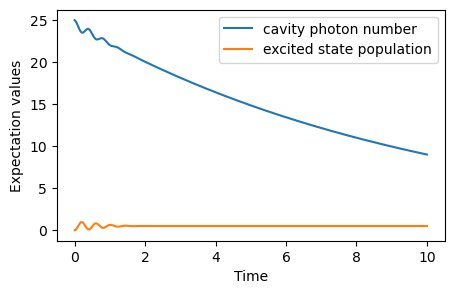

In [56]:
# short-time limit: damped Rabi oscillations
tlist = np.linspace(0,10,10000)
fock_space_size = 20
atom_space_size = 2
atom_cavity_coupling = 0.25
cavity_decay_rate = 0.1
coherent_alpha = 5

atom_coherent_state_in_leaky_cavity(tlist, fock_space_size, atom_space_size, atom_cavity_coupling, cavity_decay_rate, initial_photon_number)


# <font size=5, color = 'black'> Three-level system: Two-photon damped Rabi-Raman oscillation </font>

Consider a three-level system given by $\ket{1}, \ket{2}, \ket{3}$ where $\ket{2}$ is some intermediate, lossy, excited level. Here, $\ket{1}, \ket{3}$ are the ground states (which are not necessarily degenerate). Assume that $\ket{1}, \ket{2}$ are coupled via a field with detuning $\Delta$ and Rabi frequency $\Omega_{12}$ and $\ket{2}, \ket{3}$ are coupled via a field with detuning $\Delta + \delta$ and Rabi frequency $\Omega_{23}$. We model the lossiness of state $\ket{2}$ by considering another dummy state $\ket{4}$ to which $\ket{2}$ decays with rate $\gamma_e$. With this we have an effective four-level system, but the point just to demonstrate damped two-photon Rabi-Raman damped oscillation. 

Assume that $\Delta \gg \gamma_e$ as typically is the case. Since we do not want the excited, lossy state $\ket{2}$ to participate much, we want to set the Rabi frequencies $\Omega_{12}, \Omega_{23}$ to be small compared to $\Delta$. This process is called adiabatic elimination. We set up our solver so that the initial state is $\ket{1}$.

The end results, which we will check, are that the ground states experience a light shift $\Omega_i^2/4\Delta$, and two-photon Rabi-Raman oscillation occurs with rate 
$$\Omega_\text{Rabi-Raman} = \frac{\Omega_{12}\Omega_{23} \Delta / 2   }{\Delta^2 + \gamma_e^2/4}$$ 
and is damped at rate
$$ \Gamma_\text{Rabi-Raman} = \frac{\Omega_{12} \Omega_{23} \gamma_e / 4}{ \Delta^2 + \gamma_e^2/4} .$$

In [49]:
 # Two-photon damped Rabi-Raman oscillation solver
def two_photon_rabi_raman_damped_oscillation(tlist, levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24):

    one = levels[0]
    two = levels[1]
    three = levels[2]
    four = levels[3]

    # generate relevant projectors
    sig11 = one * one.dag()
    sig22 = two * two.dag()
    sig33 = three * three.dag()
    sig44 = four * four.dag()
    sig12 = one * two.dag()
    sig23 = two * three.dag()
    sig42 = four * two.dag() # |4><2| : sends |2> to |4>

    c_op_list = [np.sqrt(gamma_e)*sig42]

    H0 = Delta*sig11 + 0*sig22 + (Delta+delta)*sig33 + delta_24*sig44 # assuming |2> and |4> are degenerate, it doesn't matter!
    H1 = OmegaR_12*(sig12 + sig12.dag())/2.0 + OmegaR_23*(sig23 + sig23.dag())/2.0
    H = H0 + H1

    output = mesolve(H, one, tlist, c_op_list, [sig11, sig22, sig33, sig44])

    # calculate Rabi-Raman oscillation rate and Rabi-Raman damping rate:
    omega_Rabi_Raman = OmegaR_12 * OmegaR_23 * (Delta/2) / (Delta**2 + gamma_e**2/4)
    gamma_Rabi_Raman = OmegaR_12 * OmegaR_23 * (gamma_e/4) / (Delta**2 + gamma_e**2/4)

    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(tlist, output.expect[0], label='1')
    ax.plot(tlist, output.expect[1], label='2')
    ax.plot(tlist, output.expect[2], label='3')
    ax.plot(tlist, output.expect[3], label='4')
    ax.plot(tlist, np.cos(tlist * omega_Rabi_Raman/2)**2 *np.exp(-tlist * gamma_Rabi_Raman), ':' , label='analytics')
    plt.ylabel('Population')
    plt.xlabel('Time')
    ax.legend()
    plt.show()

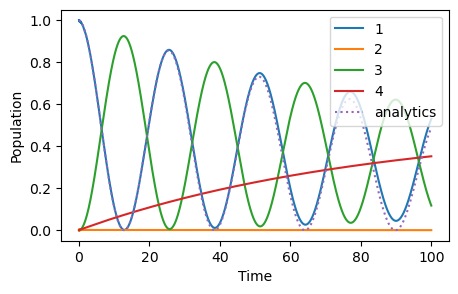

In [48]:
# Zero two-photon detuning case
gamma_e = 0.05*100
Delta = 100 # 12 detuning
delta = 0.0 # 13 two-photon detuning
OmegaR_12 = 7
OmegaR_23 = 7
delta_24 = 0.0 # energy difference between 2 & 4: it doesn't matter! 
tlist = np.linspace(0,100,100000)

# generate basis
one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
four_levels = [one, two, three, four]

# calculate
two_photon_rabi_raman_damped_oscillation(tlist, four_levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24)

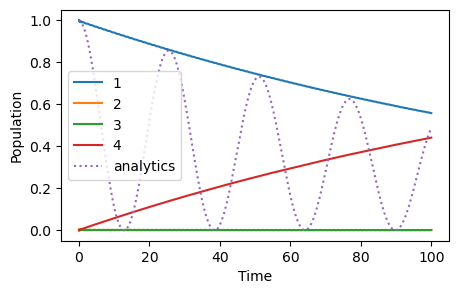

In [50]:
# Non-zero two-photon detuning case: garbage RR oscillation
gamma_e = 0.05*100
Delta = 100 # 12 detuning
delta = 5.0 # 13 two-photon detuning
OmegaR_12 = 7
OmegaR_23 = 7
delta_24 = 0.0 # energy difference between 2 & 4: it doesn't matter! 
tlist = np.linspace(0,100,100000)

# generate basis
one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
four_levels = [one, two, three, four]

# calculate
two_photon_rabi_raman_damped_oscillation(tlist, four_levels, gamma_e, Delta, delta, OmegaR_12, OmegaR_23, delta_24)

# <font size=5, color='black'> STIRAP </font>

# <font size=5, color='black'> Zeeman Effect Calculator </font>

In [ ]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mj == mjj - 1) and (mi == mii + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mj == mjj + 1 and mi == mii - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mj == mjj - 2 and mi == mii + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mj == mjj + 2 and mi == mii - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [ ]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = None,
                                search_mode = False, splitting = 0, splitting_between_states = None):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))

    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eigh(H, UPLO='L') # calculate using the lower triangular part, can also do eig() -- same result
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 0.5, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        print('Frequency spacings (MHz), from low to high in state energy, at ' + str(B_main) +  ' G:')
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensitivity of shift (MHz per G), from low to high in state energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        if print_field_sensitivity_between is not None:
            lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
            higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
            differential_shift =  higher_state - lower_state
            # take derivative:
            dfdB = np.diff(differential_shift)/np.diff(B_fields)
            print( 'Field sensitivity of splitting, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
            print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        if splitting_between_states is not None:
            state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
            state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
            AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
            AB_freq_diff_min_index = np.argmin(AB_freq_differences)

            print(' ')
            print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
            splitting_error = state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting
            print('Splitting Error (MHz): ' + "{:.5f}".format(splitting_error ))
            if np.abs(splitting_error/splitting) >= 0.1: # if error is too big
                print('Note: large error might due to bad guesses!')

    return 

In [ ]:
# Zeeman calculator cell

B_start = 0
B_end = 200
B_main = 101 # G
num_B = 1000

# Careful what you type in here!
Ahf = K40Ahf_s12
Bhf = K40Bhf_s12
L = 0
S = 1/2
J = 1/2
I = K40I
gI = K40gI

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = [1,2], plot_range = None, 
                            single_B_field_calc_mode = False, print_field_sensitivity_between = [1,2],
                            search_mode = False, splitting = 26.240, splitting_between_states = [1,2])